# Laboratorio #1 – Detección de Pishing

In [12]:
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse

In [2]:
df = pd.read_csv("dataset_pishing.csv")

In [3]:
# Mostrar un ejemplo de cinco observaciones
print("Ejemplo de cinco observaciones:")
print(df.head())


Ejemplo de cinco observaciones:
                                                 url      status
0              http://www.crestonwood.com/router.php  legitimate
1  http://shadetreetechnology.com/V4/validation/a...    phishing
2  https://support-appleld.com.secureupdate.duila...    phishing
3                                 http://rgipt.ac.in  legitimate
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate


In [4]:
status_counts = df["status"].value_counts()
print("\nCantidad de observaciones por categoría:")
print(status_counts)


Cantidad de observaciones por categoría:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64


In [5]:
balance_ratio = status_counts["legitimate"] / status_counts["phishing"] if "phishing" in status_counts else None
print("\nBalance del dataset:")
print(f"Proporción entre clases (legitimate/phishing): {balance_ratio:.2f}")


Balance del dataset:
Proporción entre clases (legitimate/phishing): 1.00


##### ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

Alguna de las ventajas pueden ser:

- Detección en tiempo real: Las páginas de phishing suelen tener una vida útil corta, a veces solo unas pocas horas. El análisis de URL permite detectar amenazas sin necesidad de cargar la página, lo que mejora la velocidad de detección​ y es por ello que se llega a detectar de manera instantanea

- Independencia de idioma: No depende del idioma del contenido de la página, lo que lo hace aplicable a sitios web globales​

- No depende de servicios de terceros: Algunos enfoques requieren consultas a servicios como WHOIS o listas negras, lo que puede ralentizar la detección y hacerla dependiente de servicios externos​

- Detección de ataques de "día cero": Puede identificar nuevas amenazas de phishing sin depender de listas de dominios maliciosos previamente identificados​


##### ¿Qué características de una URL son más prometedoras para la detección de phishing?

Algunas de las caracteristicas son:

- Observar la longitud de la URL y del dominio: Los sitios de phishing suelen usar URLs largas para ocultar la identidad real del dominio​

- Uso de direcciones IP en la URL: Los atacantes suelen usar direcciones IP en lugar de nombres de dominio​

- Número de subdominios: Los sitios de phishing tienden a incluir múltiples subdominios para parecer legítimos​

- Presencia de caracteres especiales: Caracteres como "-", "@" y "?" pueden indicar intentos de uan direccion falsa

- Uso de Punycode: Los sitios maliciosos pueden emplear caracteres Unicode en los nombres de dominio para parecer legítimos​

- HTTPS vs HTTP: Aunque algunos sitios de phishing usan HTTPS, muchos siguen operando con HTTP​

- Cantidad de números en la URL: Un número excesivo de dígitos en la URL puede indicar phishing​

- Uso de servicios de acortamiento de URL: Los atacantes usan acortadores para ocultar la URL real​

- Número de guiones en el dominio: Sitios de phishing suelen incluir guiones para imitar dominios legítimos​

- Posición del TLD: Si el TLD aparece en la parte de la ruta de la URL en lugar del dominio, puede ser indicativo de phishing​

- Presencia de palabras clave sospechosas: Palabras como "login", "secure", "bank", "update" pueden ser indicativos de phishing​

- Número de parámetros en la URL: Un alto número de parámetros puede indicar intentos de manipulación​

- Frecuencia de caracteres no alfanuméricos: La entropía de caracteres especiales puede ser usada para detectar URLs de phishing​

- Presencia de direcciones de correo en la URL: Los sitios de phishing pueden incluir direcciones de correo falsas en la URL​

- Entropía de Shannon y relativa: Mide la aleatoriedad de la cadena de la URL, útil para detectar URLs generadas automáticamente​



In [6]:
def shannon_entropy(string):
    prob = [float(string.count(c)) / len(string) for c in dict.fromkeys(list(string))]
    entropy = -sum([p * math.log2(p) for p in prob])
    return entropy

In [ ]:

def relative_entropy(string):
    return shannon_entropy(string) / math.log2(len(string)) if len(string) > 1 else 0


In [ ]:

def extract_features(url):
    parsed = urlparse(url)
    domain = parsed.netloc
    path = parsed.path
    
    features = {
        "url_length": len(url),
        "domain_length": len(domain),
        "num_subdomains": domain.count('.'),
        "contains_ip": bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', domain)),
        "num_special_chars": sum([url.count(c) for c in "-@?&|=_~%/"]),
        "https_token": 1 if url.startswith("https") else 0,
        "digit_ratio": sum(c.isdigit() for c in url) / len(url),
        "shortened_url": 1 if any(service in url for service in ["bit.ly", "goo.gl", "tinyurl"]) else 0,
        "num_hyphens": domain.count("-"),
        "tld_position": 1 if ".com/" in path or ".net/" in path else 0,
        "num_suspicious_words": sum(1 for word in ["login", "secure", "bank", "update"] if word in url),
        "num_parameters": url.count("="),
        "email_in_url": 1 if "@" in url else 0,
        "shannon_entropy": shannon_entropy(url),
        "relative_entropy": relative_entropy(url)
    }
    return features

                                                 url      status  url_length  \
0              http://www.crestonwood.com/router.php  legitimate          37   
1  http://shadetreetechnology.com/V4/validation/a...    phishing          77   
2  https://support-appleld.com.secureupdate.duila...    phishing         126   
3                                 http://rgipt.ac.in  legitimate          18   
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate          55   

   domain_length  num_subdomains  contains_ip  num_special_chars  https_token  \
0             19               2        False                  3            0   
1             23               1        False                  5            0   
2             50               4        False                 14            1   
3             11               2        False                  2            0   
4             15               2        False                  7            0   

   digit_ratio  shortened_url  .

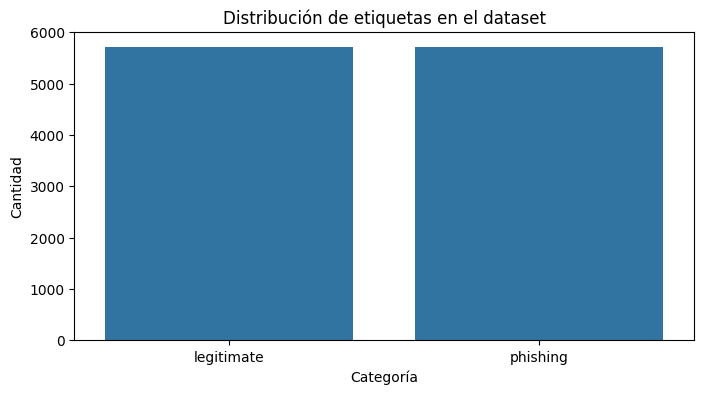

In [ ]:

df_features = df["url"].apply(lambda x: extract_features(x)).apply(pd.Series)
df = pd.concat([df, df_features], axis=1)


df.to_csv("dataset_enriquecido.csv", index=False)


print(df.head())


plt.figure(figsize=(8, 4))
sns.countplot(x=df["status"])
plt.title("Distribución de etiquetas en el dataset")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()

In [ ]:

df_features = df["url"].apply(lambda x: extract_features(x)).apply(pd.Series)
df_binaria = pd.concat([df, df_features], axis=1)

                                                 url  status  url_length  \
0              http://www.crestonwood.com/router.php       0          37   
1  http://shadetreetechnology.com/V4/validation/a...       1          77   
2  https://support-appleld.com.secureupdate.duila...       1         126   
3                                 http://rgipt.ac.in       0          18   
4  http://www.iracing.com/tracks/gateway-motorspo...       0          55   

   num_subdomains  contains_ip  num_special_chars  https_token  digit_ratio  \
0               2        False                  3            0     0.000000   
1               1        False                  5            0     0.220779   
2               4        False                 14            1     0.150794   
3               2        False                  2            0     0.000000   
4               2        False                  7            0     0.000000   

   shortened_url  num_hyphens  ...  https_token  digit_ratio  shorte

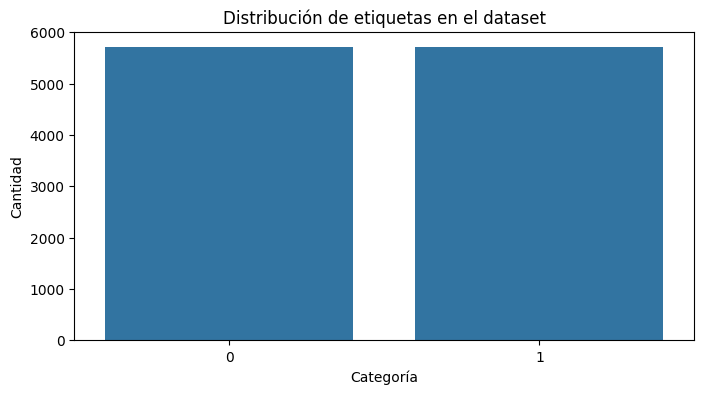

In [ ]:

df_binaria['status'] = df_binaria['status'].map({'legitimate': 0, 'phishing': 1})


df_binaria.drop(columns=['domain_length'], inplace=True, errors='ignore')


df_binaria.to_csv("dataset_enriquecido_binario.csv", index=False)


print(df_binaria.head())


plt.figure(figsize=(8, 4))
sns.countplot(x=df_binaria["status"])
plt.title("Distribución de etiquetas en el dataset")
plt.xlabel("Categoría")
plt.ylabel("Cantidad")
plt.show()
